In [1]:
# setting up everything
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys, subprocess
out = subprocess.getoutput('/bin/tcsh -c "module load tensorflow && printenv PYTHONPATH"')
sys.path = out.split("\n")[-1].split(":") + sys.path
import tensorflow as tf
from tensorflow import keras

fin  = xr.open_dataset("/lustre/ytzheng/Data/CTRC_Yannian/All_2014_NCEP_val_input.nc")
fout  = xr.open_dataset("/lustre/ytzheng/Data/CTRC_Yannian/All_2014_NCEP_val_output.nc")

In [2]:
model = keras.models.load_model('my_h5_model.h5')
prediction = model.predict(fin.arrvar.values)

In [3]:
from matplotlib import cm
myfontsize  =12

def plt2dhist(iax, ix, iy, ititle):
    my_cmap = plt.cm.magma_r
#     my_cmap = plt.cm.Spectral_r
    my_cmap.set_under('white',1)

    oax = iax.hist2d(ix, iy, bins=200, cmap = my_cmap, vmin=1 )
    
    min0, max0 = iax.get_ylim()
    min1, max1 = iax.get_xlim()
    
    min_use = min(min0, min1)
    max_use = max(max0, max1)
    
    iax.set_xlim(min_use, max_use)
    iax.set_ylim(min_use, max_use)
    iax.plot([min_use, max_use], [min_use, max_use], "--", color = 'black', linewidth=0.7)
    
    iax.set_xlabel('Truth ($W m^{-2}$)', fontsize=myfontsize)
    iax.set_ylabel('Prediction ($W m^{-2}$)', fontsize=myfontsize)
    iax.set_title(ititle, fontsize=myfontsize)
#     fig.colorbar(oax, ax = iax, orientation='horizontal')
    iax.grid(True)

    
    rmse = np.sqrt(((iy - ix) ** 2).mean())
    coeff = np.corrcoef(ix, iy)[0,1]
    
    textstr = '\n'.join((
    r'$N=%d$' % (len(ix), ),
    r'$R^2=%.2f$' % (coeff*coeff, ),
    r'$RMSE=%.2f$' % (rmse, )))
    
    iax.text(0.05, 0.95, textstr, transform=iax.transAxes, fontsize=0.7*myfontsize,
        verticalalignment='top')
    
    return oax

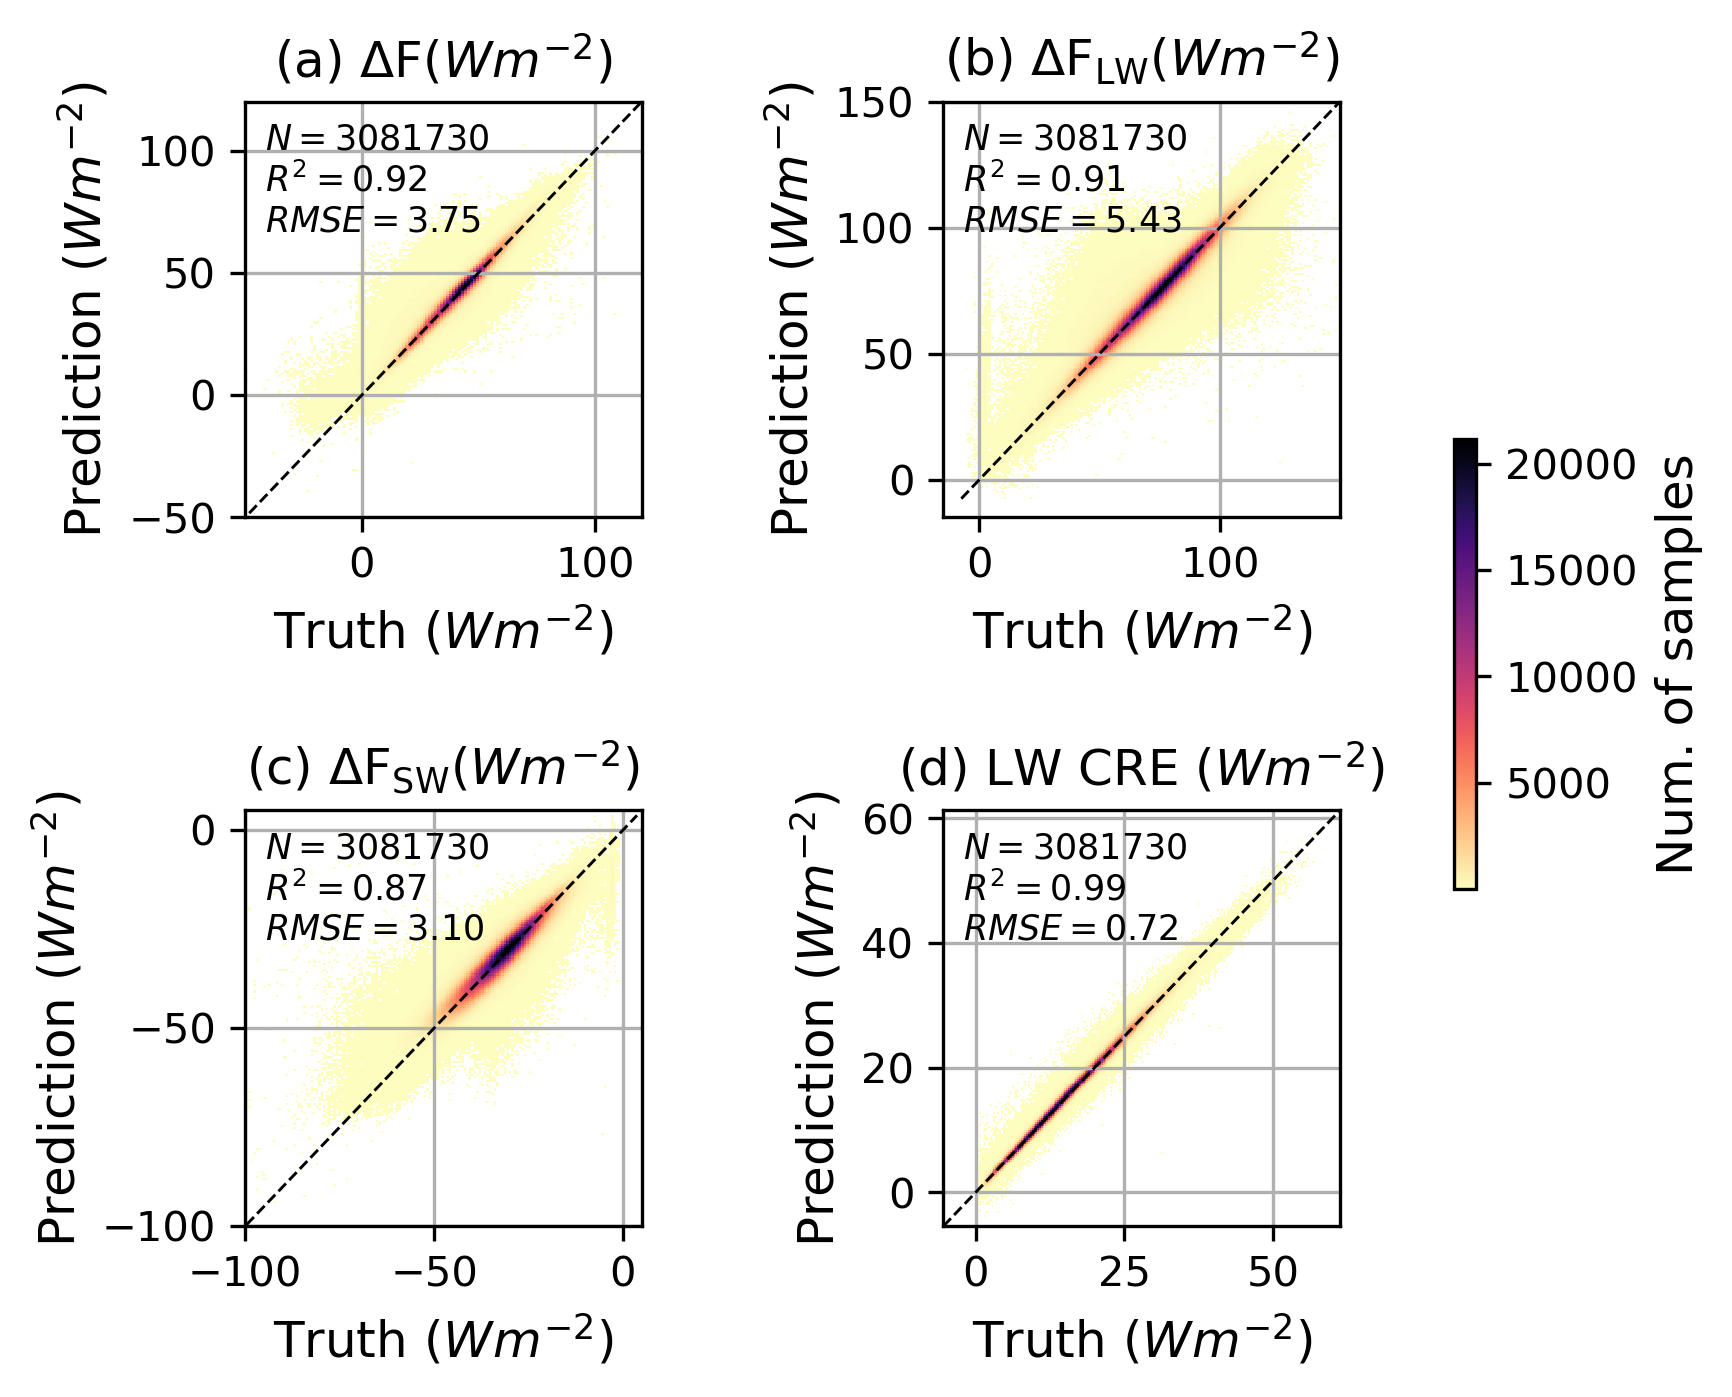

In [4]:
fig, axs = plt.subplots(ncols = 2,
                        nrows = 2,
                        sharex = False, sharey = False,
                        figsize=(14/2.54, (11)/2.54), dpi = 300)

plt.tight_layout(w_pad=6, h_pad=5.0)

# plt.tight_layout()

#fig a
oax = plt2dhist(axs[0,0], -fout.arrvar.values[:,0], -prediction[:,0], '(a) $\mathrm{\Delta F} (W m^{-2}$)')
plt2dhist(axs[0,1], -fout.arrvar.values[:,2], -prediction[:,2], '(b) $\mathrm{\Delta F_{LW}} (W m^{-2}$)')
plt2dhist(axs[1,0], -fout.arrvar.values[:,1], -prediction[:,1], '(c) $\mathrm{\Delta F_{SW}} (W m^{-2}$)')
plt2dhist(axs[1,1], -fout.arrvar.values[:,4], -prediction[:,4], '(d) LW CRE $(W m^{-2}$)')

axs[0,0].set_xlim(-50, 120)
axs[0,0].set_ylim(-50, 120)

axs[0,1].set_xlim(-15, 150)
axs[0,1].set_ylim(-15, 150)

axs[1,0].set_xlim(-100, 5)
axs[1,0].set_ylim(-100, 5)
    
cbar = fig.colorbar(oax[3],  ax=axs, orientation='vertical', 
                    shrink=0.4, pad=0.08)

cbar.set_label('Num. of samples', fontsize=myfontsize)

fig.savefig('Fig4_NN_validation_scatter.png', dpi=fig.dpi, bbox_inches='tight')